# LSTM-Based Stock Price Prediction Approach

This study aims to predict stock prices using a Long Short-Term Memory (LSTM) model for eight companies representing various industry sectors. The selection of stocks is based on industry representation to gain a broader perspective on stock price movement patterns.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# To ignores the warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Collection
Stock closing price data was collected using Yahoo Finance, covering the period from January 1, 2023, to January 1, 2025. The selected stocks represent the following industries:

| **Industry Sector**         | **Stock Ticker** |
|----------------------------|-----------------|
| Consumer Cyclical          | ACES.JK         |
| Energy                     | ADRO.JK         |
| Consumer Defensive         | AMRT.JK         |
| Basic Materials            | ANTM.JK         |
| Financial Services         | BBCA.JK         |
| Communication Services     | TLKM.JK         |
| Healthcare                 | KLBF.JK         |
| Technology                 | GOTO.JK         |


In [2]:
# Selected Stocks
selected_tickers = {
    'Consumer Cyclical': 'ACES.JK',
    'Energy': 'ADRO.JK',
    'Consumer Defensive': 'AMRT.JK',
    'Basic Materials': 'ANTM.JK',
    'Financial Services': 'BBCA.JK',
    'Communication Services': 'TLKM.JK',
    'Healthcare': 'KLBF.JK',
    'Technology': 'GOTO.JK'
}

In [3]:
tickers = list(selected_tickers.values())

data = yf.download(tickers, start='2023-01-01', end='2025-01-01')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed


## 2. Exploratory Data Analysis (EDA)

In [4]:
print(data.describe())

Ticker     ACES.JK      ADRO.JK      AMRT.JK      ANTM.JK       BBCA.JK  \
count   476.000000   476.000000   476.000000   476.000000    476.000000   
mean    710.843175  1657.436537  2843.527231  1598.465555   9237.238767   
std     147.733627   397.759769   166.469293   200.310877    755.172514   
min     393.653748  1098.984131  2554.307617  1210.000000   7639.740234   
25%     646.737732  1389.879883  2746.434875  1450.000000   8706.000732   
50%     759.226746  1492.247925  2841.419678  1566.723267   9099.252930   
75%     810.000000  1826.778687  2885.163330  1781.107788   9875.744141   
max     940.000000  2760.000000  3570.000000  2100.112305  10895.657227   

Ticker     GOTO.JK      KLBF.JK      TLKM.JK  
count   476.000000   476.000000   476.000000  
mean     83.411765  1712.645830  3358.586672  
std      22.800983   227.736148   366.041641  
min      50.000000  1275.000000  2530.000000  
25%      65.000000  1534.675018  3010.000000  
50%      84.000000  1672.950012  3486.9465

The EDA was conducted on eight selected stocks from different industry sectors, analyzing their historical closing prices. Below are the key insights from the statistical summary:

1. Count
Each stock has 476 data points, indicating that the dataset covers a significant period for meaningful trend analysis.

2. Mean and Standard Deviation
BBCA.JK (Financial Services) has the highest average stock price (9,237.24), followed by TLKM.JK (3,358.59) and AMRT.JK (2,843.53).
GOTO.JK (Technology) has the lowest average stock price (83.41).
ADRO.JK (Energy) and ANTM.JK (Basic Materials) show considerable standard deviations, suggesting higher price volatility.
3. Minimum and Maximum Prices
BBCA.JK has the highest maximum price (10,895.66) among all stocks, showing its strong growth potential.
GOTO.JK has the lowest minimum price (50.00), reinforcing its high volatility in the market.
The stock with the most stable price range appears to be AMRT.JK, as its minimum (2,554.31) and maximum (3,570.00) are relatively close.
4. Quartile Distribution
BBCA.JK and TLKM.JK show a steady price increase over time, as indicated by their interquartile range (IQR).
ANTM.JK shows a broader spread between Q1 (1,450.00) and Q3 (1,781.11), indicating fluctuating performance.
GOTO.JK has a wide gap between Q1 (65.00) and Q3 (104.00), further confirming its price instability.

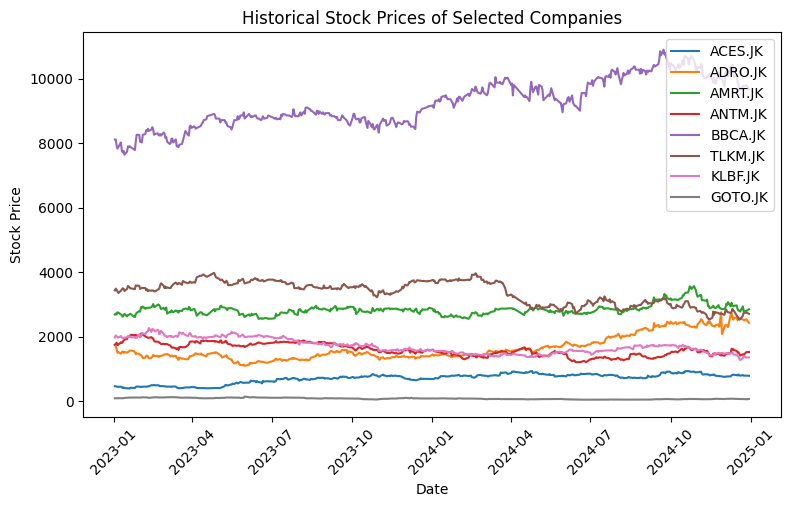

In [5]:
# EDA: Visualization of stock price trends
plt.figure(figsize=(9, 5))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)
plt.legend()
plt.title('Historical Stock Prices of Selected Companies')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.show()

From the visualization of stock price trends, there are no drastic changes, and the movement tends to be stagnant in the long term.

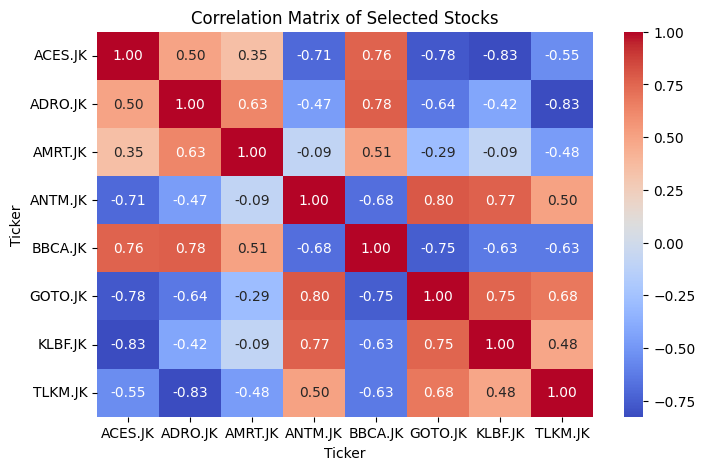

In [6]:
# EDA: Correlation between stocks
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Stocks')
plt.show()

The correlation heatmap provides insights into the relationships between different stocks. Key observations:

- Strong Positive Correlations
    1. BBCA.JK & ADRO.JK (0.78): These stocks tend to move in the same direction, possibly influenced by macroeconomic factors.
    2. KLBF.JK & ANTM.JK (0.77): These two stocks also exhibit a strong positive correlation.
    3. GOTO.JK & ANTM.JK (0.80): A high correlation suggests that movements in ANTM.JK are often mirrored in GOTO.JK.
- Negative Correlations
    1. ACES.JK & ANTM.JK (-0.71): These stocks tend to move in opposite directions, meaning when ACES.JK increases, ANTM.JK often declines.
    2. BBCA.JK & ANTM.JK (-0.68): This suggests that the banking sector and basic materials industry might be influenced by opposing market conditions.
    3. TLKM.JK & ADRO.JK (-0.83): A strong negative correlation suggests an inverse relationship between the telecommunication and energy sectors.
- Weak or No Correlation
    1. AMRT.JK & ANTM.JK (-0.09): These two stocks appear to be independent, with minimal correlation in price movement.
    2. AMRT.JK & KLBF.JK (-0.09): A similar lack of correlation suggests that consumer defensive and healthcare sectors operate under different market influences.

## 3. Data Preparations and Modelling

**Data Preparations**
- Normalization: Stock prices were normalized using MinMaxScaler to scale values between 0 and 1, ensuring stable model training.
- Sequence Data Creation: Data was transformed into sequential form with a 50-day window size, allowing the model to learn stock price movement patterns.
- Train-Test Split: The dataset was split into 80% training and 20% testing.

**Modelling**
The LSTM model used in this study consists of the following architecture:
- LSTM Layer 1: 50 units with return sequences enabled.
- Dropout Layer: 20% to reduce overfitting.
- LSTM Layer 2: 50 units without return sequences.
- Dropout Layer: 20%.
- Dense Layer: 25 neurons.
- Output Layer: 1 neuron to predict the next stock price.
- Optimizer: Adam with a learning rate of 0.001.
- Loss Function: Mean Squared Error (MSE).
- Epochs: 50, with a batch size of 32.

**Model Evaluation Metrics**
The model performance was assessed using multiple evaluation metrics:
- Mean Squared Error (MSE): Measures the average squared difference between actual and predicted values. Lower values indicate better performance.
- Root Mean Squared Error (RMSE): The square root of MSE, providing an interpretable measure in the same unit as the stock prices.
- Mean Absolute Error (MAE): Represents the average absolute difference between actual and predicted values.
- Mean Absolute Percentage Error (MAPE): Expressed as a percentage, indicating the average deviation of predictions from actual values.
- Directional Accuracy (DA): Measures the percentage of correct directional movements (up/down) between actual and predicted stock prices.

In [7]:
# Function to create LSTM data sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Time series window length

In [8]:
def calculate_directional_accuracy(y_actual, y_pred):
    actual_direction = np.sign(np.diff(y_actual.flatten()))
    pred_direction = np.sign(np.diff(y_pred.flatten()))
    correct_direction = np.sum(actual_direction == pred_direction)
    return (correct_direction / len(actual_direction)) * 100

Processing ACES.JK...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


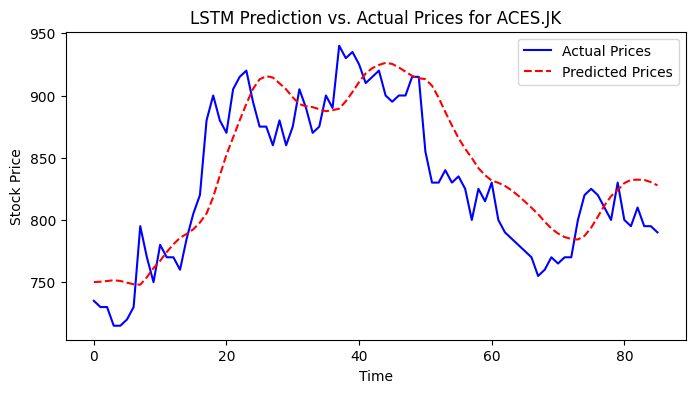

ACES.JK - MSE: 1078.1756, RMSE: 32.8356, MAE: 27.6744, MAPE: 3.35%, DA: 44.71%
Processing ADRO.JK...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


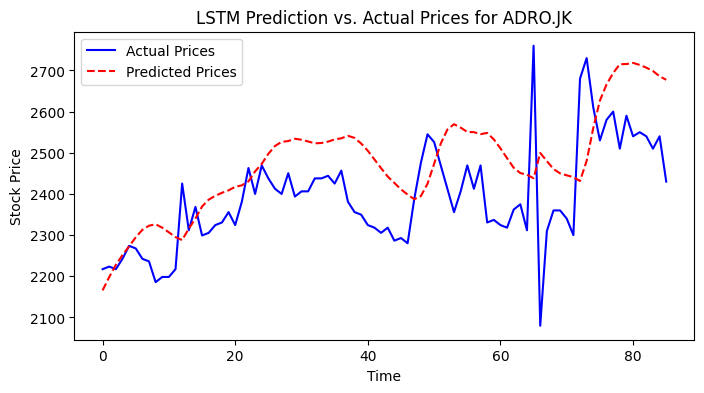

ADRO.JK - MSE: 18500.3913, RMSE: 136.0161, MAE: 115.8970, MAPE: 4.84%, DA: 42.35%
Processing AMRT.JK...
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E3C7D513A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step


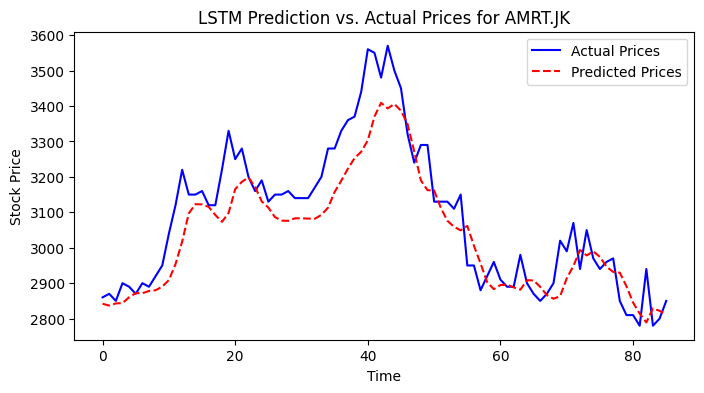

AMRT.JK - MSE: 8160.3650, RMSE: 90.3347, MAE: 70.6500, MAPE: 2.23%, DA: 37.65%
Processing ANTM.JK...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


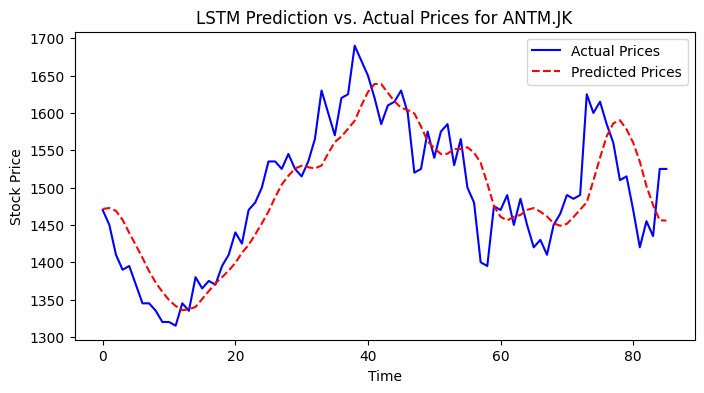

ANTM.JK - MSE: 2596.2304, RMSE: 50.9532, MAE: 40.4289, MAPE: 2.71%, DA: 45.88%
Processing BBCA.JK...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


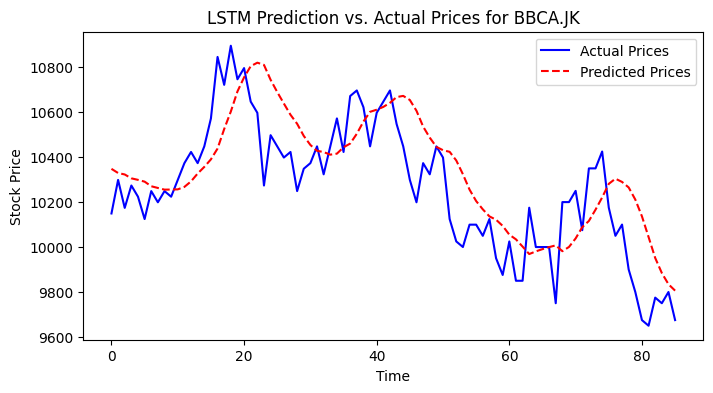

BBCA.JK - MSE: 40086.9474, RMSE: 200.2173, MAE: 160.0468, MAPE: 1.57%, DA: 50.59%
Processing TLKM.JK...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


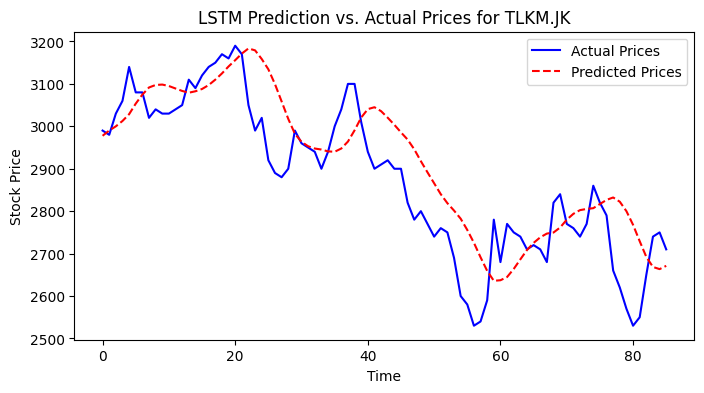

TLKM.JK - MSE: 10768.1693, RMSE: 103.7698, MAE: 82.2222, MAPE: 2.93%, DA: 44.71%
Processing KLBF.JK...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step


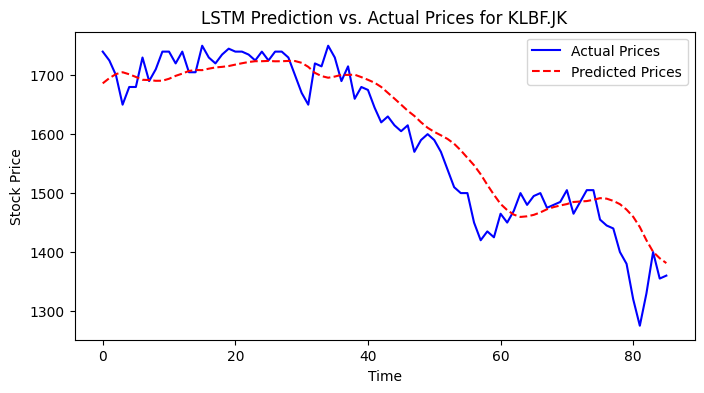

KLBF.JK - MSE: 2182.8249, RMSE: 46.7207, MAE: 35.1167, MAPE: 2.30%, DA: 45.88%
Processing GOTO.JK...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


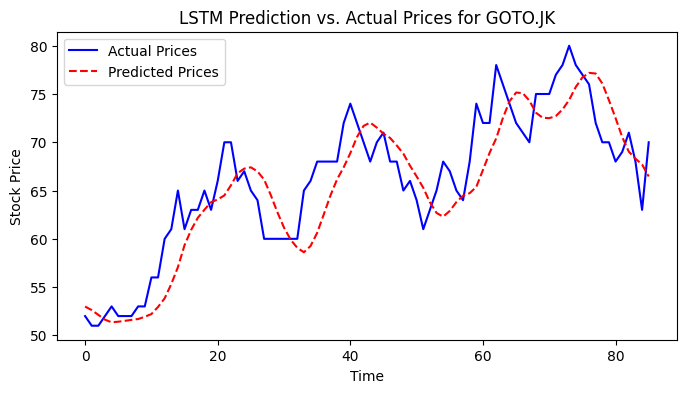

GOTO.JK - MSE: 13.4129, RMSE: 3.6624, MAE: 3.0030, MAPE: 4.47%, DA: 40.00%


In [9]:
results = {}

for ticker in tickers:
    print(f'Processing {ticker}...')
    dataframe = data[[ticker]]
    stock = dataframe.values.reshape(-1, 1)
    
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_scaled = scaler.fit_transform(stock)
    
    # Create data sequence
    X, y = create_sequences(stock_scaled, seq_length)
    
    # Train-test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # LSTM
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Train model
    epochs = 50
    batch_size = 32
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
    # Stock price prediction
    y_pred = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Model evaluation
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
    da = calculate_directional_accuracy(y_test_actual, y_pred_actual)
    
    # Visualisasi hasil prediksi vs. data aktual
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual Prices', color='blue')
    plt.plot(range(len(y_pred_actual)), y_pred_actual, label='Predicted Prices', color='red', linestyle='dashed')
    plt.legend()
    plt.title(f'LSTM Prediction vs. Actual Prices for {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.show()
    
    results[ticker] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'DA': da, 'Model': model, 'Scaler': scaler, 'Data': stock_scaled}
    
    print(f'{ticker} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, DA: {da:.2f}%')



Among all these metrics, Directional Accuracy (DA) is chosen as the key decision-making criterion. This is because in stock trading, accurately predicting the direction of price movement (whether it increases or decreases) is more valuable for investors than minimizing absolute errors.

Thus, the best-performing stock prediction model is selected based on the highest DA score, ensuring more reliable investment insights.

In [10]:
# Determining the top 3 stocks based on DA
top_3_stocks = sorted(results.keys(), key=lambda k: results[k]['DA'], reverse=True)[:3]
print(f'Top 3 stocks for prediction by DA: {top_3_stocks}')

Top 3 stocks for prediction by DA: ['BBCA.JK', 'ANTM.JK', 'KLBF.JK']


## 4. Forecasting

**1-Month Ahead Prediction**

For the top-performing stocks, a 20-day forward prediction (assuming stock market working days) was performed using an iterative approach:

Using the latest window as input.
The newly predicted price is added to the sequence to predict the next day's price.

In [12]:
# 1 month forward prediction for top 3 stocks (assuming 1 month 20 working days)
Total_predict=20

In [13]:
def predict_future(model, data, dataframe, seq_length, scaler, days):
    future_predictions = []
    current_input = data[-seq_length:].tolist()
    last_date = dataframe.index[-1] + pd.offsets.BDay(1)
    future_dates = pd.bdate_range(start=last_date, periods=days)
    
    for _ in range(days):
        current_input_array = np.array(current_input).reshape(1, seq_length, 1)
        next_pred = model.predict(current_input_array)[0][0]
        future_predictions.append(next_pred)
        current_input.append([next_pred])
        current_input.pop(0)
    
    future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_dates, future_prices

**BBCA**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


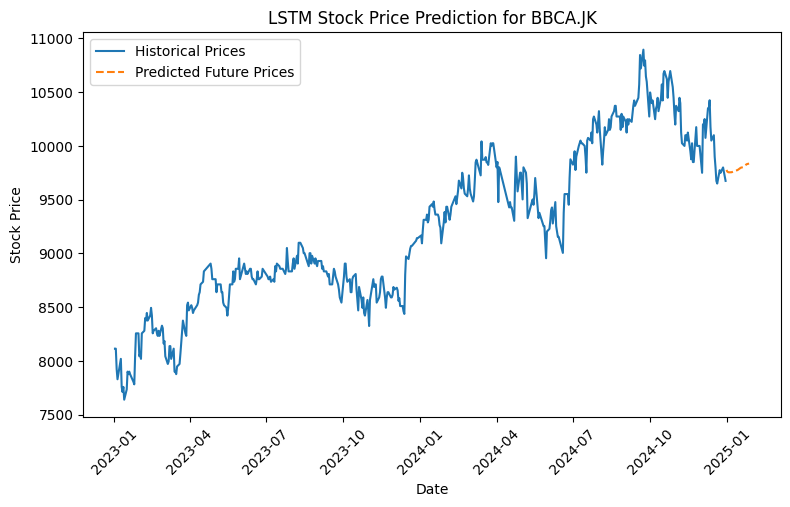

In [14]:
stock = 'BBCA.JK'
best_model = results[stock]['Model']
best_scaler = results[stock]['Scaler']
best_data = results[stock]['Data']
df_best = data[[stock]]
    
future_dates, future_prices = predict_future(best_model, best_data, df_best, seq_length, best_scaler, Total_predict)
    
# Visualization of future predictions
plt.figure(figsize=(9, 5))
plt.plot(df_best.index, df_best.values, label='Historical Prices')
plt.plot(future_dates, future_prices, label='Predicted Future Prices', linestyle='dashed')
plt.legend()
plt.title(f'LSTM Stock Price Prediction for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Create a DataFrame to view the prediction results.
future_df = pd.DataFrame({'Day': range(1, Total_predict+1), 'Predicted Price': future_prices.flatten()})
print(f'Predictions for {stock}:')
print(future_df)

Predictions for BBCA.JK:
    Day  Predicted Price
0     1      9776.003906
1     2      9762.086914
2     3      9756.114258
3     4      9754.503906
4     5      9755.379883
5     6      9757.752930
6     7      9761.096680
7     8      9765.115234
8     9      9769.641602
9    10      9774.569336
10   11      9779.832031
11   12      9785.376953
12   13      9791.164062
13   14      9797.164062
14   15      9803.349609
15   16      9809.701172
16   17      9816.202148
17   18      9822.833984
18   19      9829.584961
19   20      9836.444336


**ANTM**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


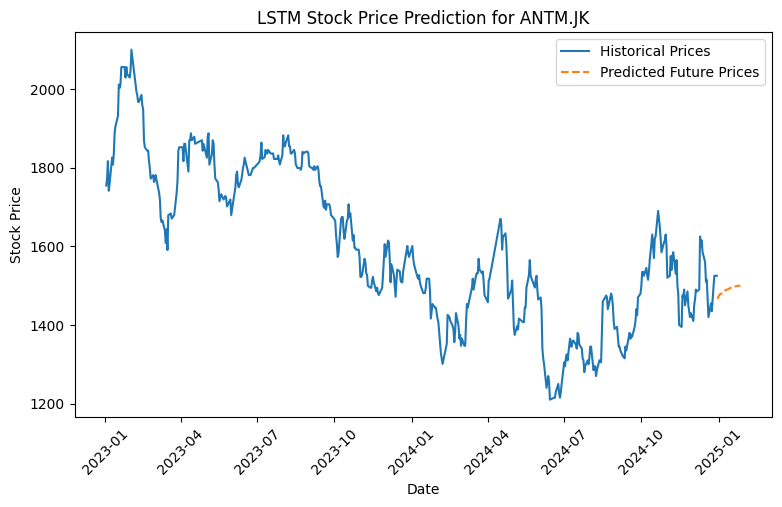

In [16]:
stock = 'ANTM.JK'
best_model = results[stock]['Model']
best_scaler = results[stock]['Scaler']
best_data = results[stock]['Data']
df_best = data[[stock]]
    
future_dates, future_prices = predict_future(best_model, best_data, df_best, seq_length, best_scaler, Total_predict)
    
# Visualization of future predictions
plt.figure(figsize=(9, 5))
plt.plot(df_best.index, df_best.values, label='Historical Prices')
plt.plot(future_dates, future_prices, label='Predicted Future Prices', linestyle='dashed')
plt.legend()
plt.title(f'LSTM Stock Price Prediction for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.show()

In [17]:
# Create a DataFrame to view the prediction results.
future_df = pd.DataFrame({'Day': range(1, Total_predict+1), 'Predicted Price': future_prices.flatten()})
print(f'Predictions for {stock}:')
print(future_df)

Predictions for ANTM.JK:
    Day  Predicted Price
0     1      1466.435913
1     2      1472.286011
2     3      1475.985474
3     4      1478.723267
4     5      1481.059326
5     6      1483.230103
6     7      1485.315063
7     8      1487.321167
8     9      1489.224976
9    10      1490.998901
10   11      1492.617310
11   12      1494.063477
12   13      1495.329468
13   14      1496.412109
14   15      1497.316162
15   16      1498.055786
16   17      1498.644409
17   18      1499.101074
18   19      1499.447144
19   20      1499.700317


**KLBF**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


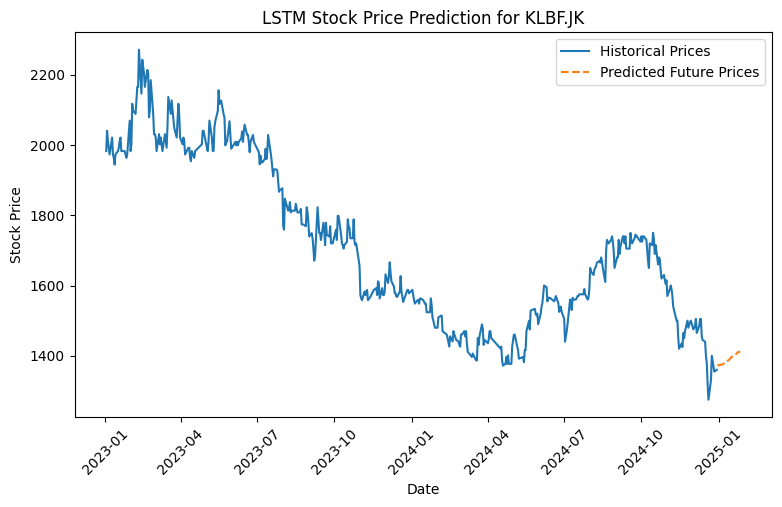

In [18]:
stock = 'KLBF.JK'
best_model = results[stock]['Model']
best_scaler = results[stock]['Scaler']
best_data = results[stock]['Data']
df_best = data[[stock]]
    
future_dates, future_prices = predict_future(best_model, best_data, df_best, seq_length, best_scaler, Total_predict)
    
# Visualization of future predictions
plt.figure(figsize=(9, 5))
plt.plot(df_best.index, df_best.values, label='Historical Prices')
plt.plot(future_dates, future_prices, label='Predicted Future Prices', linestyle='dashed')
plt.legend()
plt.title(f'LSTM Stock Price Prediction for {stock}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Create a DataFrame to view the prediction results.
future_df = pd.DataFrame({'Day': range(1, Total_predict+1), 'Predicted Price': future_prices.flatten()})
print(f'Predictions for {stock}:')
print(future_df)

Predictions for KLBF.JK:
    Day  Predicted Price
0     1      1375.624023
1     2      1373.251343
2     3      1372.857056
3     4      1373.665771
4     5      1375.206909
5     6      1377.193604
6     7      1379.450439
7     8      1381.869507
8     9      1384.384033
9    10      1386.951416
10   11      1389.544189
11   12      1392.144531
12   13      1394.739136
13   14      1397.319946
14   15      1399.880249
15   16      1402.414917
16   17      1404.919922
17   18      1407.392090
18   19      1409.828979
19   20      1412.229004


## 5. Conclusion
Based on the prediction results, the top three stocks with the lowest MAPE and highest Directional Accuracy (DA) are BBCA, KLBF, and ANTM.

- BBCA is the most reliable choice, with the lowest prediction error and strong trend consistency.
- KLBF follows closely, showing stable growth potential.
- ANTM also demonstrates a positive trend but with slightly higher prediction error.

For beginner investors, these three stocks present promising investment opportunities due to their strong upward trends and high prediction accuracy. 